In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim
import tqdm

# Generate data

In [2]:
input_x = np.random.uniform(0, 3, size=1000)
output_y = np.round(input_x + np.random.randn(1000) * 0.05)

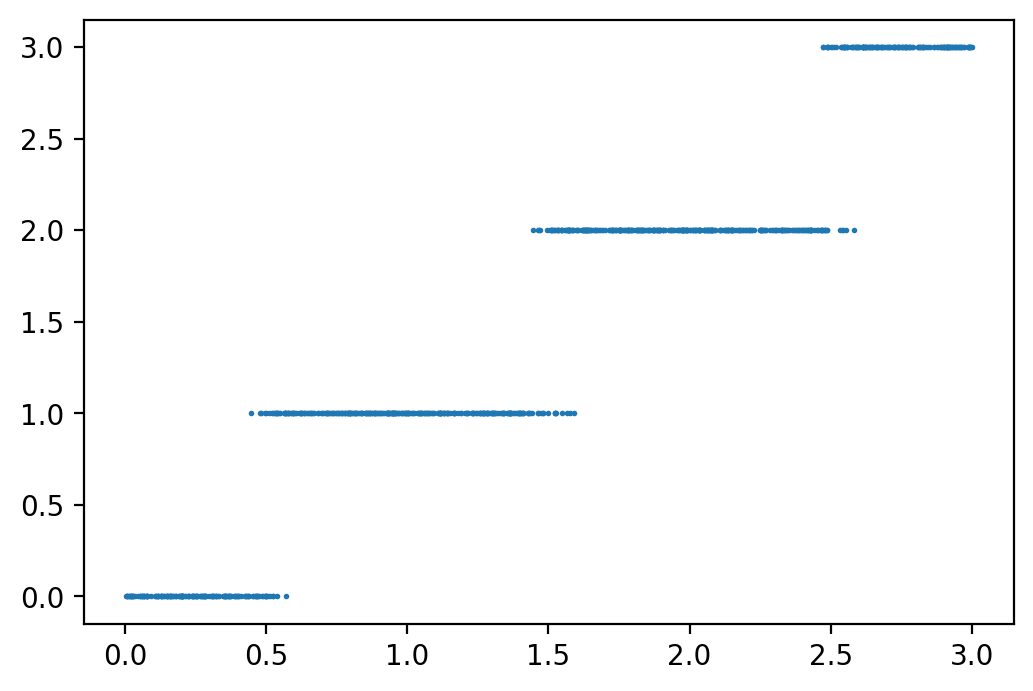

In [3]:
plt.figure(dpi=200)
plt.scatter(input_x, output_y, s=1)

# Sigma model

In [4]:
class SigmaModule(nn.Module):
    def __init__(self):
        super().__init__()
        self._classificator = nn.Linear(1, 3)
        self._regressor = nn.Linear(3, 1)
    
    def forward(self, x):
        x = self._classificator(x)
        x = torch.sigmoid(x)
        x = self._regressor(x)
        return x

In [5]:
model = SigmaModule()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-1)

In [6]:
input_data = torch.tensor(input_x[:, None].astype(np.float32))
output_data = torch.tensor(output_y[:, None].astype(np.float32))
losses = []
iteration_count = 10000
for i in tqdm.tqdm(range(iteration_count)):
    model.zero_grad()
    predicted = model(input_data)
    loss = loss_function(predicted, output_data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(
100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1249.67it/s]


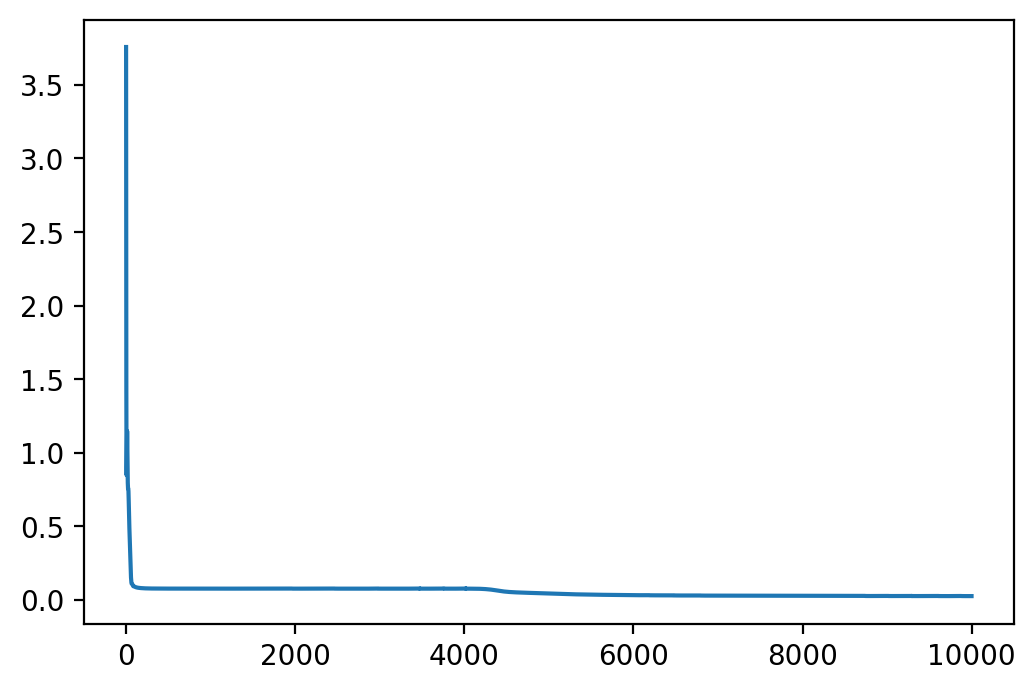

In [7]:
plt.figure(dpi=200)
plt.plot(losses)

In [8]:
losses[-1]

0.02684759721159935

In [9]:
final_predicted = model(input_data).detach().cpu().numpy()[:, 0]

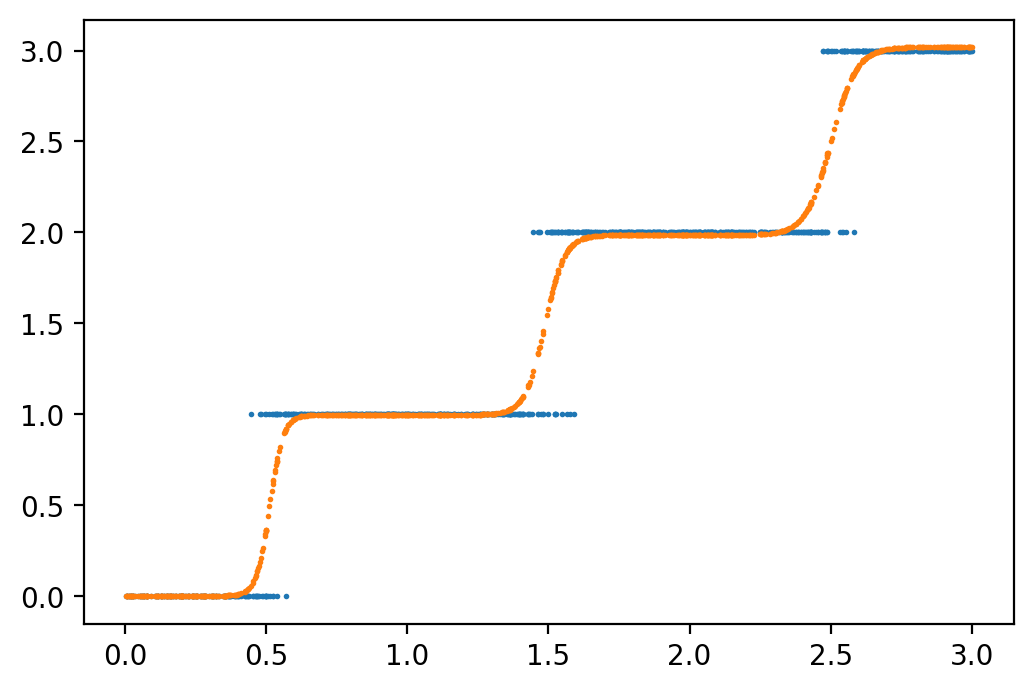

In [10]:
plt.figure(dpi=200)
plt.scatter(input_x, output_y, s=1)
plt.scatter(input_x, final_predicted, s=1)

In [11]:
class SigmaStochasticModule(nn.Module):
    def __init__(self):
        super().__init__()
        self._classificator = nn.Linear(1, 3)
        self._regressor = nn.Linear(3, 1)
    
    def forward(self, x):
        x = self._classificator(x)
        probability = torch.sigmoid(x)
        a = torch.bernoulli(probability)
        c = (a - probability).detach()
        x = c + probability
        x = self._regressor(x)
        return x

In [12]:
model = SigmaStochasticModule()
loss_function = nn.HuberLoss(delta=0.1)
optimizer = torch.optim.Adam(model.parameters(), 1e-1)
input_data = torch.tensor(input_x[:, None].astype(np.float32))
output_data = torch.tensor(output_y[:, None].astype(np.float32))
losses = []
iteration_count = 10000
for i in tqdm.tqdm(range(iteration_count)):
    model.zero_grad()
    predicted = model(input_data)
    loss = loss_function(predicted, output_data)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1566.75it/s]


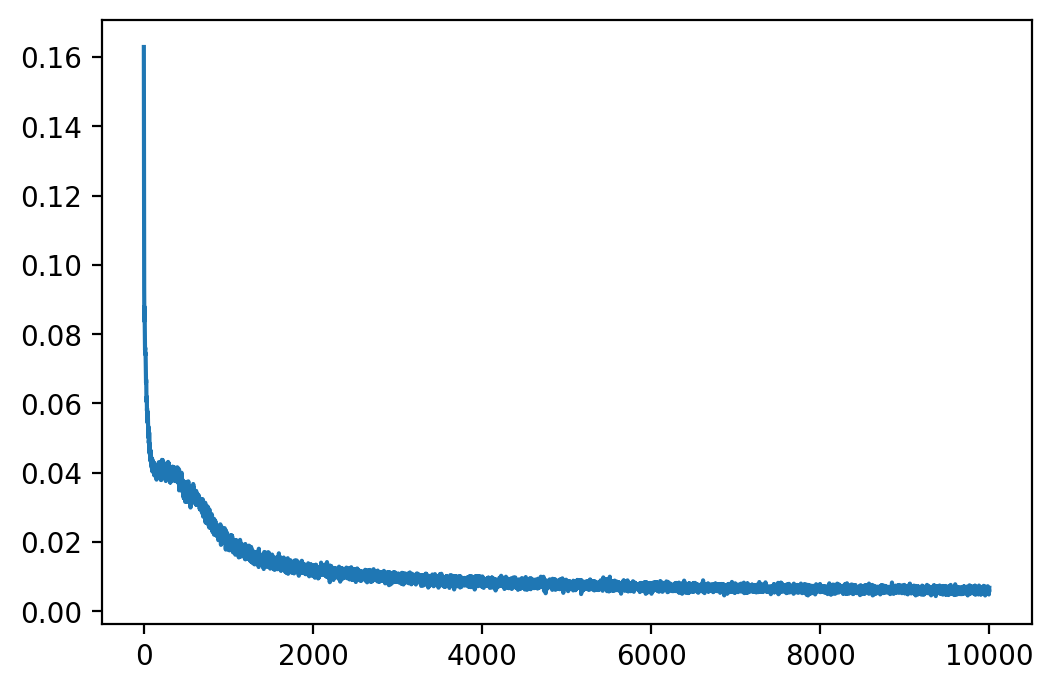

In [13]:
plt.figure(dpi=200)
plt.plot(losses)

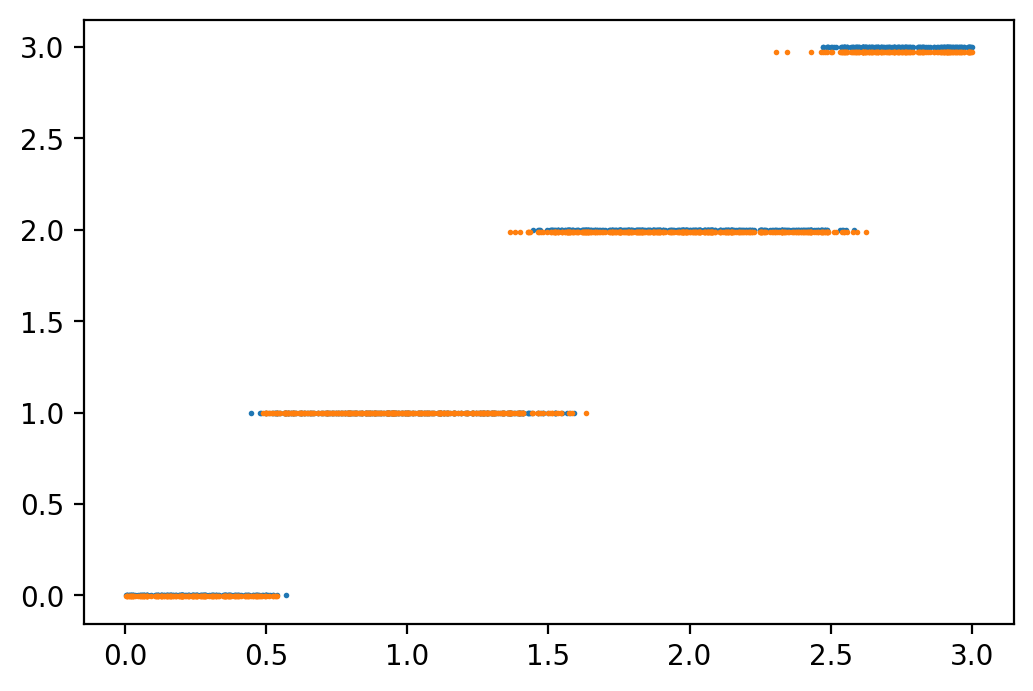

In [14]:
final_predicted = model(input_data).detach().cpu().numpy()[:, 0]
plt.figure(dpi=200)
plt.scatter(input_x, output_y, s=1)
plt.scatter(input_x, final_predicted, s=1)

In [15]:
losses[-1]

0.006757016759365797

# Score function stochastic varaiance inference

In [67]:
class SigmaScoreFunctionModule(nn.Module):
    def __init__(self):
        super().__init__()
        self._classificator = nn.Linear(1, 3)
        self._regressor = nn.Linear(3, 1)
    
    def forward(self, x):
        x = self._classificator(x)
        probability = torch.sigmoid(x)
        a = torch.bernoulli(probability).detach() 
        log_prob = torch.logsumexp(torch.stack([x, torch.zeros_like(x)]), dim=0)
#         print(a)
        log_prob = (a * (x - log_prob) + (1 - a) * (-log_prob))
        x = self._regressor(a)
        return x, log_prob

In [88]:
model = SigmaScoreFunctionModule()
loss_function = nn.HuberLoss(delta=0.1)
optimizer = torch.optim.SGD(model.parameters(), 3e-3)
input_data = torch.tensor(input_x[:, None].astype(np.float32))
output_data = torch.tensor(output_y[:, None].astype(np.float32))
losses = []
log_probs = []
iteration_count = 10000
for i in tqdm.tqdm(range(iteration_count)):
    model.zero_grad()
    predicted, log_prob = model(input_data)
    loss = loss_function(predicted, output_data)
    losses.append(loss.item())
    log_probs.append(torch.sum(log_prob).item())
    loss = loss + torch.sum(log_prob) * (loss.detach() - 0.01)
    loss.backward()
    optimizer.step()
    

100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1360.20it/s]


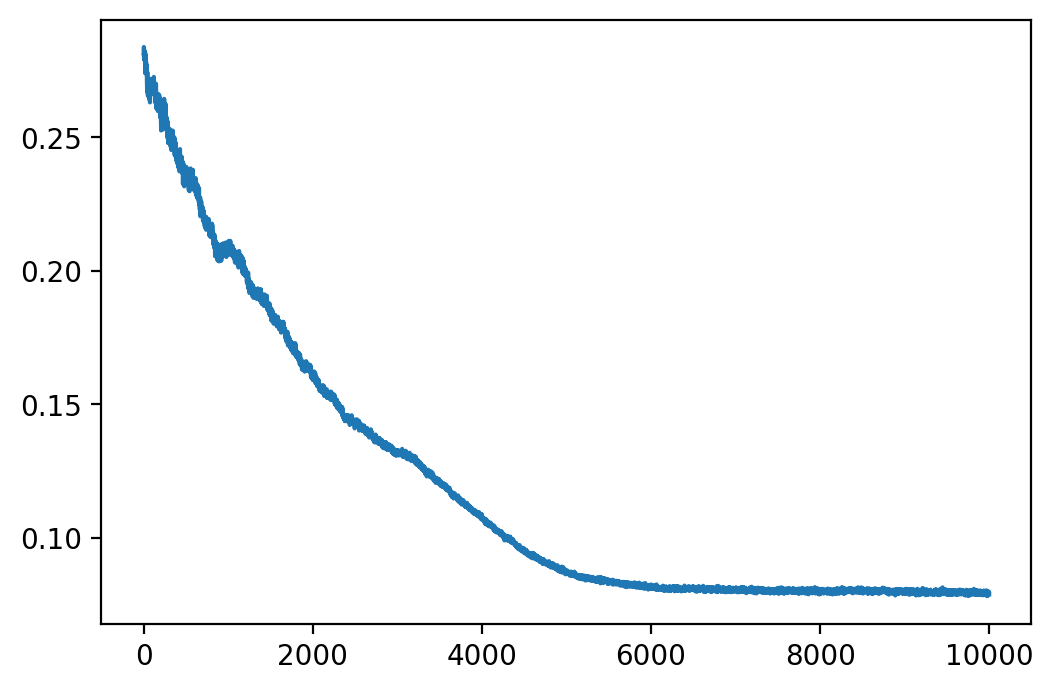

In [85]:
plt.figure(dpi=200)
plt.plot(losses)

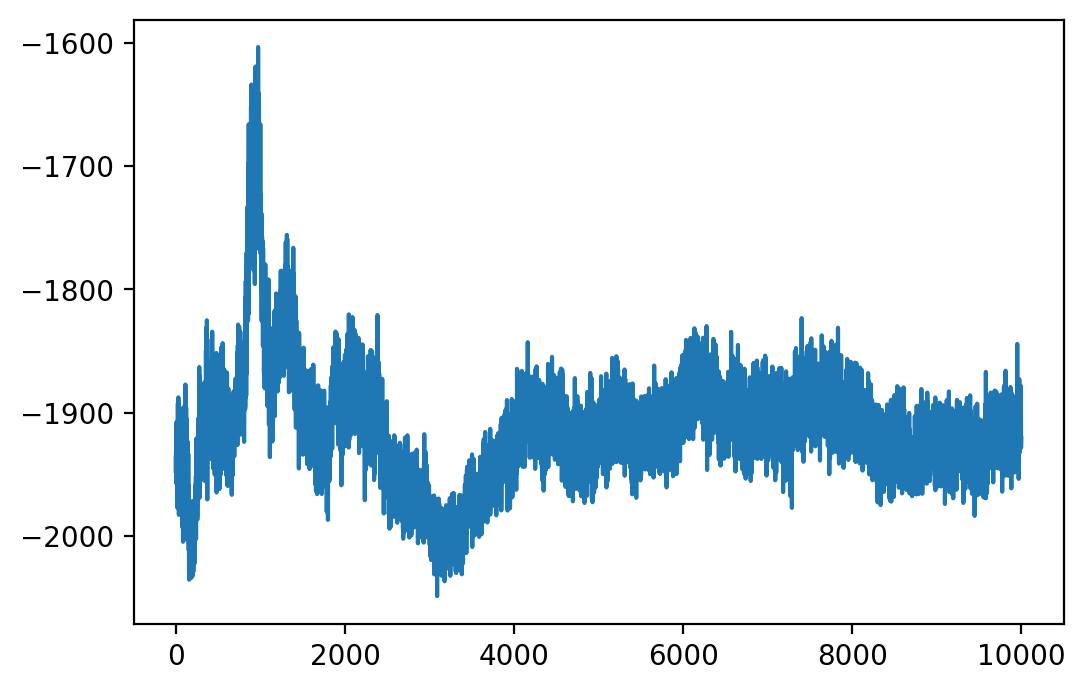

In [86]:
plt.figure(dpi=200)
plt.plot(log_probs)

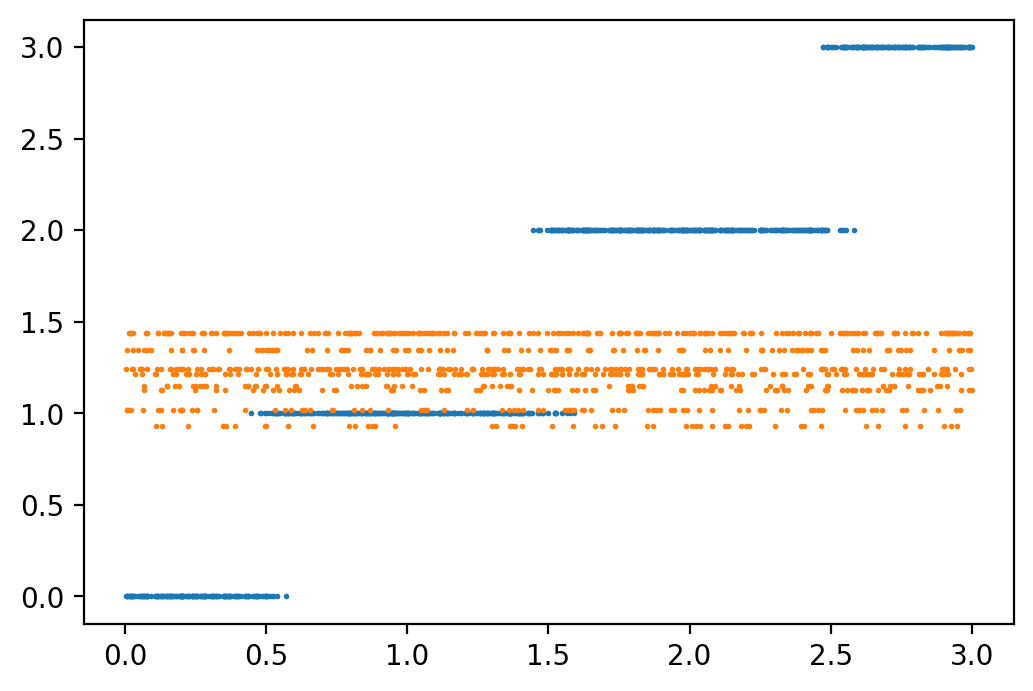

In [87]:
final_predicted = model(input_data)[0].detach().cpu().numpy()[:, 0]
plt.figure(dpi=200)
plt.scatter(input_x, output_y, s=1)
plt.scatter(input_x, final_predicted, s=1)

In [47]:
losses[-1]

0.9182549118995667